In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

frame_delay = 6
data_path = "../vision-enc-data/enc_vis.txt"

In [11]:
data_raw = pd.read_csv(data_path, sep=" ")
data_raw = data_raw.drop("bot_id", axis=1) # no need for bot id here

#data = data_raw.iloc[1212:2500]
data = data_raw

In [12]:
data.head(frame_delay*2) # Show off some of our csv

,x,y,ang,enc0,enc1,enc2,enc3
0,2451.46,-1177.88,1.48449,0,0,0,0
1,2456.61,-1177.04,1.46944,0,0,0,0
2,2453.99,-1175.43,1.47952,0,0,0,0
3,2450.48,-1178.02,1.47516,0,0,0,0
4,2456.04,-1175.12,1.48188,0,0,0,0
5,2451.75,-1177.95,1.47758,0,0,0,0
6,2454.87,-1176.50,1.49438,0,0,0,0
7,2455.35,-1175.60,1.49042,0,0,0,0
8,2454.68,-1175.38,1.46833,0,0,0,0
9,2453.99,-1175.43,1.47749,0,0,0,0


In [13]:
# at time t, we have just received a vision packet and encoder value for the frame
# we need to take most recent vision + delta position due to encoders to get a 
# good position estimate

# note, we haven't accumulated enough encoder values to make an estimate in the first
# frame_delay frames, so we simply assume encoders are 0
run_encs = np.array([0, 0, 0, 0])

encs = []
poses = []

def row_to_enc(row):
    return np.array([row["enc0"], row["enc1"], row["enc2"], row["enc3"]], "int64")

def row_to_pose(row):
    return np.array([row["x"], row["y"], row["ang"]], "float64")

# let's build the predicted position estimate
for time_ind in range(0, len(data)):
    # we'll predict over the full range of data
    row = data.iloc[time_ind]
    pose = row_to_pose(row)
    # we want a sum of encoder values over last "frame_delay" cycles
    # add this cycle's encoder values, subtract frame_delay ago encoder cycles
    run_encs += row_to_enc(row)
    if (time_ind - frame_delay) >= 0:
        old_row = data.iloc[time_ind-frame_delay]
        run_encs -= row_to_enc(data.iloc[time_ind-frame_delay])
    
    poses.append(pose.copy())
    encs.append(run_encs.copy())

In [14]:
enc_mat = np.matrix(encs, "int64")
mm_to_meters = 1/1000.0
pose_mat = np.matrix(poses, "float64")
pose_mat[:,0:2] = pose_mat[:,0:2] * mm_to_meters

In [15]:
# now we need our wheel to bot and bot to wheel conversions
# this comes straight out of robot_model.cpp
wheel_dist = 0.0798576;
wheel_radius = 0.02786;

# M1 M2 M3 M4
wheel_angs = np.matrix([180 - 30, 180 + 39, 360 - 39, 0 + 30])
wheel_angs = np.deg2rad(wheel_angs).T

# Construct bot to wheel matrix, column by column
b2w_col1 = -np.sin(wheel_angs)
b2w_col2 = np.cos(wheel_angs)
b2w_col3 = wheel_dist * np.ones((4, 1))

b2w = np.concatenate((b2w_col1, b2w_col2, b2w_col3), axis=1)
b2w *= -1 # our wheels spin opposite
b2w /= wheel_radius

# Construct wheel to bot matrix
w2b = np.linalg.inv((b2w.T * b2w)) * b2w.T

enc_ticks_per_rev = 2048*3
dt = 1/60.0
# enc2pos will convert from encoder ticks to delta position
# in body frame
enc2pos = w2b * 2*np.pi / enc_ticks_per_rev

time = np.arange(len(poses))*dt

In [16]:
delta_enc_poses = (enc2pos * enc_mat.T).T
# this is in terms of body relative position, not global
# so we need to rotate the x, y pair into global frame

for vis_ang, enc_pose_row in zip(pose_mat[:,2], delta_enc_poses):
    x, y = enc_pose_row[0,0], enc_pose_row[0,1]
    angle = -np.pi / 2 + vis_ang

    new_x = x * np.cos(angle) - y * np.sin(angle)
    new_y = y * np.cos(angle) + x * np.sin(angle)
    enc_pose_row[0,0], enc_pose_row[0,1] = new_x, new_y

In [17]:
# now we can get our vision+odometry estimates
pred_poses = pose_mat + delta_enc_poses

<IPython.core.display.Javascript object>


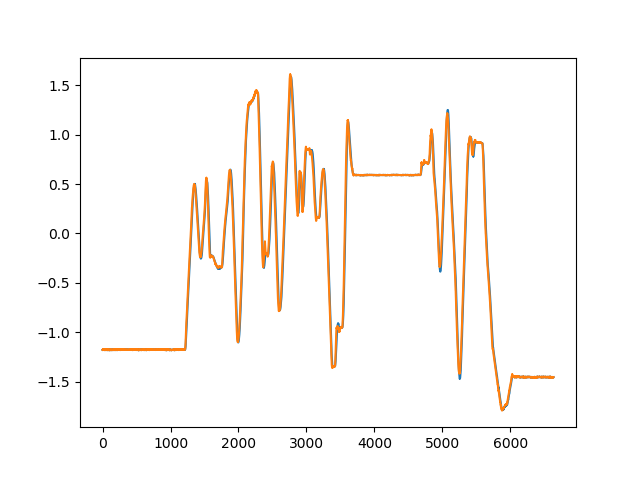

In [18]:
# ...and plot
%matplotlib notebook

plt.close()

#plt.subplot(1,3,1)
# plot x
#plt.plot(pose_mat[:,0])
#plt.plot(pred_poses[:,0])

#plt.subplot(1,3,2)
# plot y
plt.plot(pose_mat[:,1])
plt.plot(pred_poses[:,1])

#plt.subplot(1,3,3)
# plot ang
#plt.plot(np.unwrap(pose_mat[:,2], axis=0))
#plt.plot(np.unwrap(pred_poses[:,2], axis=0))

plt.show()